In [196]:
from PIL import Image
import torch
import os
import numpy as np
import pickle
from utils.utils import *
from utils.file_utils import save_pkl, load_pkl
from models.resnet_custom import resnet50_baseline
from models.model_clam import CLAM_MB, CLAM_SB
from torch.utils.data import DataLoader
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import cv2 as cv

In [197]:
cmap='coolwarm'

In [198]:
if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)

In [199]:
heatmap_mask = np.zeros([1024, 1536, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.9725490196078398


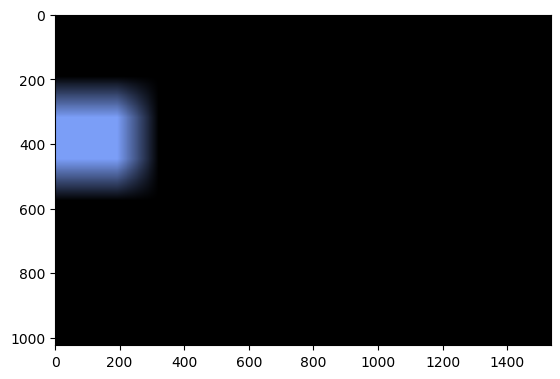

In [200]:
score = 0.2
x = 256
y = 0
patch_size = (256, 256)

raw_block = np.ones([256, 256])
color_block = (cmap(raw_block*score) * 255)[:,:,:3].astype(np.uint8)
heatmap_mask[x:x+patch_size[0], y:y+patch_size[1], :] = color_block.copy()/255
# print(heatmap_mask)

overlap = 0.5
heatmap_mask = cv.blur(heatmap_mask,(128, 128))
print(heatmap_mask.max())
plt.imshow(heatmap_mask)